## SVM Training

Bu notebook SVM sınıflandırıcısını eğitmek için kullanılır. Ham veri, filtrelenmiş veri ve temizlenmiş veri kullanılarak eğitim yapılır. Eğitim için ayrılan veri oranı %85, test için ayrılan veri oranı %15'tir. İlk olarak validation seti oluşturularak eğitim yapılır. Daha sonra cross validation ile eğitim yapılır. 

Metinlerin vektörlerleri tf-idf ile oluşturulmuştur. TF-IDF için çeşitli parametreler denenmiştir. 

SVM için çeşitli parametreler denenmiştir. Mlflow kullanılarak deneyler kaydedilmiştir. 


Denenen  tüm parametreler aşağıda verilmiştir.

| Parametre | Değerler |
|-----------|----------|
| tfidfmax_features | 50, 100, 200, 500 |
| tfidfngram_range | (1,2), (2,3), (1,3) |
| svmkernel | linear, rbf, poly, sigmoid |
| svmclass_weight | balanced |
| svmgamma | scale |
| svmdegree | 2, 3, 4 |

Grid Search ile en iyi parametreler bulunmuştur. En iyi parametreler aşağıda verilmiştir.
En İyi Parametreler:
| Parametre | Değer |
|-----------|-------|
| svmclass_weight | balanced |
| svmgamma | scale |
| svmkernel | rbf |
| tfidfmax_features | 5000 |
| tfidfngram_range | (1, 2) |

Deneyleri özetleyecek bir tablo aşağıda verilmiştir.

| Veri Seti | Model | Accuracy | Precision | Recall | F1 Score |
|-----------|-------|----------|-----------|---------|-----------|
| Ham (Validation) | SVM | 0.9817 | 0.9715 | 0.9797 | 0.9756 |
| Ham (Test) | SVM | **_0.9837_** | 0.9796 | **_0.9766_** | **_0.9781_** |
| Filtrelenmiş (Validation) | SVM | 0.9851 | 0.9753 | **0.9850** | 0.9801 |
| Filtrelenmiş (Test) | SVM | **_0.9837_** | 0.9796 | **_0.9766_** | **_0.9781_** |
| Temizlenmiş (Validation) | SVM | **0.9856** | **0.9765** | **0.9850** | **0.9808** |
| Temizlenmiş (Test) | SVM | 0.9829 | **_0.9805_** | 0.9736 | 0.9770 |


In [20]:
import mlflow
import mlflow.sklearn
import os

# Mlflow için gerekli ayarlar yapılır
mlruns_dir = os.path.join(os.path.dirname(os.getcwd()), "mlruns")
os.makedirs(mlruns_dir, exist_ok=True)

mlflow.set_tracking_uri(f"file://{mlruns_dir}")
 
experiment_name = "SVM-HF-demo"
try:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
except Exception as e:
    print(f"MLflow ayarlanırken hata oluştu: {e}")

In [6]:
from sklearn.model_selection import train_test_split

# Her veri seti için train ve validation ayırma işlemi
def split_and_save_validation(train_data, file_prefix, test_data, val_size=0.15, random_state=42):
    train_final, val_data = train_test_split(
        train_data,
        test_size=val_size,
        random_state=random_state,
        stratify=train_data['label']
    )
    
    print(f"\n{file_prefix} veri seti dağılımı:")
    print(f"Train seti: {len(train_final)} örnek")
    print(f"Validation seti: {len(val_data)} örnek")
    print(f"Test seti: {len(test_data)} örnek")
    
    
    print(f"\nTrain seti sınıf dağılımı:")
    print(train_final['label'].value_counts(normalize=True).round(4) * 100, "%")
    print(f"\nValidation seti sınıf dağılımı:")
    print(val_data['label'].value_counts(normalize=True).round(4) * 100, "%")
    print(f"\nTest seti sınıf dağılımı:")
    print(test_data['label'].value_counts(normalize=True).round(4) * 100, "%")
    
    
    train_path = f'../source/data/{file_prefix}_train_val_excluded.csv'
    val_path = f'../source/data/{file_prefix}_validation.csv'
    
    train_final.to_csv(train_path, index=False)
    val_data.to_csv(val_path, index=False)
    
    print(f"\nDosyalar kaydedildi:")
    print(f"Train: {train_path}")
    print(f"Validation: {val_path}")
    
    return train_final, val_data


In [5]:
import pandas as pd
import os

# Veri setleri yüklenir
data_dir = os.path.join(os.path.dirname(os.getcwd()), "source", "data")
raw_train_data = pd.read_csv(os.path.join(data_dir, "hf-train-data.csv"))
raw_test_data = pd.read_csv(os.path.join(data_dir, "hf-test-data.csv"))
print(f"raw train data shape: {raw_train_data.shape}")
print(f"raw test data shape: {raw_test_data.shape}")

filtered_train_data = pd.read_csv(os.path.join(data_dir, "filtered_train.csv"))
filtered_test_data = pd.read_csv(os.path.join(data_dir, "filtered_test.csv"))
print(f"filtered train data shape: {filtered_train_data.shape}")
print(f"filtered test data shape: {filtered_test_data.shape}")

cleaned_train_data = pd.read_csv(os.path.join(data_dir, "clean_filtered_train.csv"))
cleaned_test_data = pd.read_csv(os.path.join(data_dir, "clean_filtered_test.csv"))
print(f"clean train data shape: {cleaned_train_data.shape}")
print(f"clean test data shape: {cleaned_test_data.shape}")

raw train data shape: (14905, 3)
raw test data shape: (2630, 3)
filtered train data shape: (14353, 5)
filtered test data shape: (2630, 4)
clean train data shape: (14353, 6)
clean test data shape: (2630, 5)


### Veri setleri için train ve validation ayırma

Veri setleri aşağıdaki gibi dağıtılmıştır.

| Veri Seti | Train | Validation | Test |
|--------------|-------|------------|------|
| Ham | 12669 | 2236 | 2630 |
| Filtrelenmiş | 12200 | 2153 | 2630 |
| Temizlenmiş | 12200 | 2153 | 2630 |

In [7]:

# Ham veri seti için ayırma
print("Ham veri seti işleniyor...")
raw_train_final, raw_val_data = split_and_save_validation(
    raw_train_data, 
    'raw',
    raw_test_data
)

# Filtrelenmiş veri seti için ayırma
print("\nFiltrelenmiş veri seti işleniyor...")
filtered_train_final, filtered_val_data = split_and_save_validation(
    filtered_train_data,
    'filtered',
    filtered_test_data
)

# Temizlenmiş veri seti için ayırma
print("\nTemizlenmiş veri seti işleniyor...")
cleaned_train_final, cleaned_val_data = split_and_save_validation(
    cleaned_train_data,
    'cleaned',
    cleaned_test_data
)


summary_data = {
    'Veri Seti': ['Ham', 'Filtrelenmiş', 'Temizlenmiş'],
    'Train': [len(raw_train_final), len(filtered_train_final), len(cleaned_train_final)],
    'Validation': [len(raw_val_data), len(filtered_val_data), len(cleaned_val_data)],
    'Test': [len(raw_test_data), len(filtered_test_data), len(cleaned_test_data)]
}

summary_df = pd.DataFrame(summary_data)
print("\nÖzet Tablo:")
print(summary_df.to_string(index=False))

Ham veri seti işleniyor...

raw veri seti dağılımı:
Train seti: 12669 örnek
Validation seti: 2236 örnek
Test seti: 2630 örnek

Train seti sınıf dağılımı:
label
0    62.61
1    37.39
Name: proportion, dtype: float64 %

Validation seti sınıf dağılımı:
label
0    62.61
1    37.39
Name: proportion, dtype: float64 %

Test seti sınıf dağılımı:
label
0    62.62
1    37.38
Name: proportion, dtype: float64 %

Dosyalar kaydedildi:
Train: ../source/data/raw_train_val_excluded.csv
Validation: ../source/data/raw_validation.csv

Filtrelenmiş veri seti işleniyor...

filtered veri seti dağılımı:
Train seti: 12200 örnek
Validation seti: 2153 örnek
Test seti: 2630 örnek

Train seti sınıf dağılımı:
label
0    62.75
1    37.25
Name: proportion, dtype: float64 %

Validation seti sınıf dağılımı:
label
0    62.75
1    37.25
Name: proportion, dtype: float64 %

Test seti sınıf dağılımı:
label
0    62.62
1    37.38
Name: proportion, dtype: float64 %

Dosyalar kaydedildi:
Train: ../source/data/filtered_train_val

## SVM eğitimi

Bu kısımda SVM sınıflandırıcısı eğitilir. Eğitim için ayrılan veri setleri kullanılır. Sırasıyla ham, filtrelenmiş ve temizlenmiş veri setleri eğitilir. Tüm parametre setleri grid search ile optimize edilmiştir.



In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import numpy as np

def optimize_svm_parameters(
    train_data, 
    val_data, 
    test_data,
    dataset_name,
    text_column,
    experiment_name,
    cv=3,
    n_jobs=-1  # Tüm CPU çekirdeklerini kullan
):
    """
    Pipeline ve GridSearchCV kullanarak SVM parametrelerini optimize eder
    """
 
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('svm', SVC())
    ])
    
    param_grid = {
        'tfidf__max_features': [100, 200, 500, 1000, 5000],
        'tfidf__ngram_range': [(1,2), (2,3), (1,3)],
        'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'svm__class_weight': ['balanced'],
        'svm__gamma': ['scale'],
    }

    with mlflow.start_run(experiment_id=mlflow.get_experiment_by_name(experiment_name).experiment_id):
        # GridSearchCV ile parametre optimizasyonu
        grid_search = GridSearchCV(
            pipeline,
            param_grid=[param_grid],  
            cv=cv,
            n_jobs=n_jobs,
            scoring='f1',
            verbose=1
        )
        
        # Eğitim
        grid_search.fit(train_data[text_column], train_data['label'])
        
        # En iyi parametreler
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        
        # Validation seti üzerinde değerlendirme
        val_pred = best_model.predict(val_data[text_column])
        val_metrics = {
            'val_accuracy': accuracy_score(val_data['label'], val_pred),
            'val_precision': precision_score(val_data['label'], val_pred),
            'val_recall': recall_score(val_data['label'], val_pred),
            'val_f1': f1_score(val_data['label'], val_pred)
        }
        
        # Test seti üzerinde değerlendirme
        test_pred = best_model.predict(test_data[text_column])
        test_metrics = {
            'test_accuracy': accuracy_score(test_data['label'], test_pred),
            'test_precision': precision_score(test_data['label'], test_pred),
            'test_recall': recall_score(test_data['label'], test_pred),
            'test_f1': f1_score(test_data['label'], test_pred)
        }
        
      
        mlflow.log_params({
            "dataset": dataset_name,
            **best_params
        })
        mlflow.log_metrics({**val_metrics, **test_metrics})
        
        # Sonuçları yazdır
        print(f"\nEn iyi parametreler: {best_params}")
        print(f"\nValidation metrikleri:")
        for metric, value in val_metrics.items():
            print(f"{metric}: {value:.4f}")
        print(f"\nTest metrikleri:")
        for metric, value in test_metrics.items():
            print(f"{metric}: {value:.4f}")
        
    return best_model, best_params

In [33]:

optimization_experiment_name = "SVM-Optimizasyon"
try:
    experiment = mlflow.get_experiment_by_name(optimization_experiment_name)
    if experiment is None:
        mlflow.create_experiment(optimization_experiment_name)
    mlflow.set_experiment(optimization_experiment_name)
    
except Exception as e:
    print(f"MLflow ayarlanırken hata oluştu: {e}")
best_model_raw, best_params_raw = optimize_svm_parameters(
    raw_train_final,
    raw_val_data,
    raw_test_data,
    "raw_data",
    "email_text",
    optimization_experiment_name,
    cv=3)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


/Users/tczeuslu/Desktop/zgu/env/conda/phishing-email-detection/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



En iyi parametreler: {'svm__class_weight': 'balanced', 'svm__gamma': 'scale', 'svm__kernel': 'rbf', 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 2)}

Validation metrikleri:
val_accuracy: 0.9817
val_precision: 0.9715
val_recall: 0.9797
val_f1: 0.9756

Test metrikleri:
test_accuracy: 0.9837
test_precision: 0.9796
test_recall: 0.9766
test_f1: 0.9781


### En iyi parametreler ile diğer veri setleri için eğitim

Bu adımdan sonra en iyi parametreler ile diğer veri setleri için eğitim yapılır.

Accuracy, Precision, Recall ve F1 Score metrikleri ile modellerin performansı değerlendirilir.

### Confusion Matrix

Confusion matrix ile modelin performansı değerlendirilir. Validation ve test setleri için confusion matrix oluşturulur.
Confusion matrisi, bir sınıflandırma modelinin performansını; gerçek pozitif, yanlış pozitif, gerçek negatif ve yanlış negatif değerlerini göstererek, modelin tahminlerinin gerçek etiketlere ne kadar uyduğunu görsel olarak sunan bir tablodur.

Confusion Matrix'teki değerler:

**TP (True Positive):** Doğru tahmin edilen pozitif örnekler

**TN (True Negative):** Doğru tahmin edilen negatif örnekler

**FP (False Positive):** Yanlış tahmin edilen pozitif örnekler

**FN (False Negative):** Yanlış tahmin edilen negatif örnekler


**Accuracy = (TP + TN) / (TP + TN + FP + FN)**

**Precision = TP / (TP + FP)**

**Recall = TP / (TP + FN)**

**F1 = 2 * (Precision * Recall) / (Precision + Recall)**

TP = 100, TN = 50, FP = 10, FN = 5

**Accuracy = (100 + 50) / (100 + 50 + 10 + 5) = 0.909**

**Precision = 100 / (100 + 10) = 0.909**

Recall = 100 / (100 + 5) = 0.952

F1 = 2 * (0.909 * 0.952) / (0.909 + 0.952) = 0.930


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_and_log_confusion_matrix(y_true, y_pred, title, filename, figsize=(10,8)):
    """
    Confusion matrix oluşturur, görselleştirir ve MLflow'a kaydeder
    """
    # Confusion matrix hesapla
    cm = confusion_matrix(y_true, y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    
    plt.figure(figsize=figsize)
    
    sns.heatmap(cm, 
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['Güvenli', 'Oltalama'],
                yticklabels=['Güvenli', 'Oltalama'])
    
    plt.title(title)
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    
    plt.savefig(filename)
    mlflow.log_artifact(filename)
    
    # Confusion matrix metriklerini MLflow'a kaydet
    mlflow.log_metrics({
        f"{title}_true_negatives": tn,
        f"{title}_false_positives": fp,
        f"{title}_false_negatives": fn,
        f"{title}_true_positives": tp
    })
    
    plt.show()
    
    # Metrikleri yazdır
    print(f"\n{title}")
    print(f"True Negatives (Güvenli doğru tahmin): {tn}")
    print(f"False Positives (Güvenli yanlış tahmin): {fp}")
    print(f"False Negatives (Oltalama yanlış tahmin): {fn}")
    print(f"True Positives (Oltalama doğru tahmin): {tp}")

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import joblib
def train_and_evaluate_svm(train_data, val_data, test_data, dataset_name,
                            experiment_name, out_dir, text_column='email_text'):
    """
    En iyi parametrelerle SVM modeli eğitilir, değerlendirilir ve MLflow'da takip edilir.
    """
    # MLflow deneyini ayarla
    try:
        experiment = mlflow.get_experiment_by_name(experiment_name)
        if experiment is None:
            mlflow.create_experiment(experiment_name)
        mlflow.set_experiment(experiment_name)
    except Exception as e:
        print(f"MLflow ayarlanırken hata oluştu: {e}")
        
    # En iyi parametreler
    best_params = {
        'tfidf__max_features': 5000,
        'tfidf__ngram_range': (1, 2),
        'svm__kernel': 'rbf',
        'svm__class_weight': 'balanced',
        'svm__gamma': 'scale'
    }
    
    with mlflow.start_run(run_name=f"SVM_{dataset_name}"):
        # Pipeline oluştur
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(
                max_features=best_params['tfidf__max_features'],
                ngram_range=best_params['tfidf__ngram_range']
            )),
            ('svm', SVC(
                kernel=best_params['svm__kernel'],
                class_weight=best_params['svm__class_weight'],
                gamma=best_params['svm__gamma']
            ))
        ])
        
        # Modeli eğit
        pipeline.fit(train_data[text_column], train_data['label'])
        
        # Tahminleri yap
        val_pred = pipeline.predict(val_data[text_column])
        test_pred = pipeline.predict(test_data[text_column])
        
        # Metrikleri hesapla
        val_metrics = {
            'val_accuracy': accuracy_score(val_data['label'], val_pred),
            'val_precision': precision_score(val_data['label'], val_pred),
            'val_recall': recall_score(val_data['label'], val_pred),
            'val_f1': f1_score(val_data['label'], val_pred)
        }
        
        test_metrics = {
            'test_accuracy': accuracy_score(test_data['label'], test_pred),
            'test_precision': precision_score(test_data['label'], test_pred),
            'test_recall': recall_score(test_data['label'], test_pred),
            'test_f1': f1_score(test_data['label'], test_pred)
        }
        
        # MLflow'a parametreleri ve metrikleri kaydet
        mlflow.log_params({
            "dataset": dataset_name,
            **best_params
        })
        mlflow.log_metrics({**val_metrics, **test_metrics})
        
        # Modeli MLflow'a kaydet
        mlflow.sklearn.log_model(pipeline, "model")
        os.makedirs(out_dir, exist_ok=True)
        
          
        # Model dosya yolları
        svm_path = os.path.join(out_dir, f"{dataset_name}_svm.joblib")
        tfidf_path = os.path.join(out_dir, f"{dataset_name}_tfidf.joblib")
        
        # Modelleri kaydet
        joblib.dump(pipeline["svm"], svm_path)
        joblib.dump(pipeline["tfidf"], tfidf_path)
        
        print(f"\nModeller kaydedildi:")
        print(f"SVM: {svm_path}")
        print(f"TF-IDF: {tfidf_path}")
        # Confusion matrix'leri görselleştir ve kaydet
        plot_and_log_confusion_matrix(
            val_data['label'],
            val_pred,
            'Validation Seti Confusion Matrix',
            os.path.join(out_dir, f"validation_confusion_matrix_{dataset_name}.png")
        )
        
        plot_and_log_confusion_matrix(
            test_data['label'],
            test_pred,
            'Test Seti Confusion Matrix',
            os.path.join(out_dir, f"test_confusion_matrix_{dataset_name}.png")
        )
        
        # Sonuçları yazdır
        print(f"\nValidation metrikleri:")
        for metric, value in val_metrics.items():
            print(f"{metric}: {value:.4f}")
            
        print(f"\nTest metrikleri:")
        for metric, value in test_metrics.items():
            print(f"{metric}: {value:.4f}")
        
    return pipeline, val_pred, test_pred


2024/12/31 02:16:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Modeller kaydedildi:
SVM: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/svm/raw/raw_data_svm.joblib
TF-IDF: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/svm/raw/raw_data_tfidf.joblib


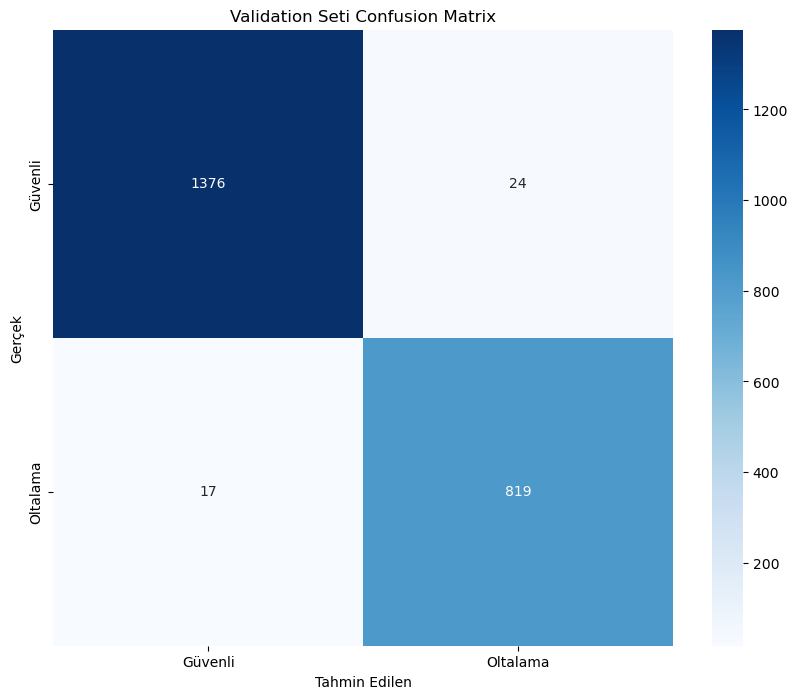


Validation Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1376
False Positives (Güvenli yanlış tahmin): 24
False Negatives (Oltalama yanlış tahmin): 17
True Positives (Oltalama doğru tahmin): 819


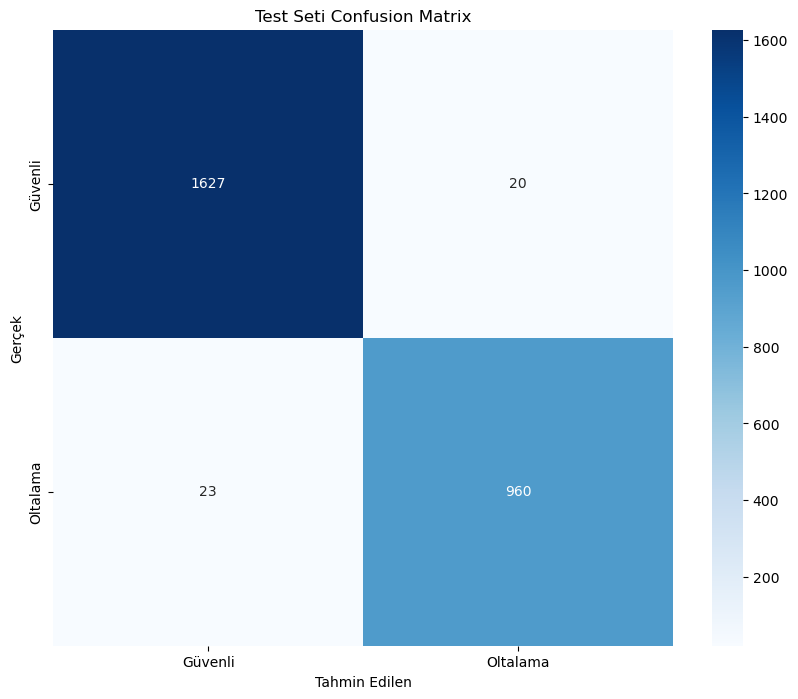


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1627
False Positives (Güvenli yanlış tahmin): 20
False Negatives (Oltalama yanlış tahmin): 23
True Positives (Oltalama doğru tahmin): 960

Validation metrikleri:
val_accuracy: 0.9817
val_precision: 0.9715
val_recall: 0.9797
val_f1: 0.9756

Test metrikleri:
test_accuracy: 0.9837
test_precision: 0.9796
test_recall: 0.9766
test_f1: 0.9781


In [15]:
experiment_name = "SVM-HF-demo"

# Ham veri seti için eğitim
model, val_pred, test_pred = train_and_evaluate_svm(
    train_data=raw_train_final,
    val_data=raw_val_data,
    test_data=raw_test_data,
    dataset_name="raw_data",
    experiment_name=experiment_name,
    out_dir=os.path.join(os.path.dirname(os.getcwd()), "source", "models", "svm","raw"),
    text_column='email_text'
)



2024/12/31 02:17:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Modeller kaydedildi:
SVM: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/svm/filtered/filtered_data_svm.joblib
TF-IDF: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/svm/filtered/filtered_data_tfidf.joblib


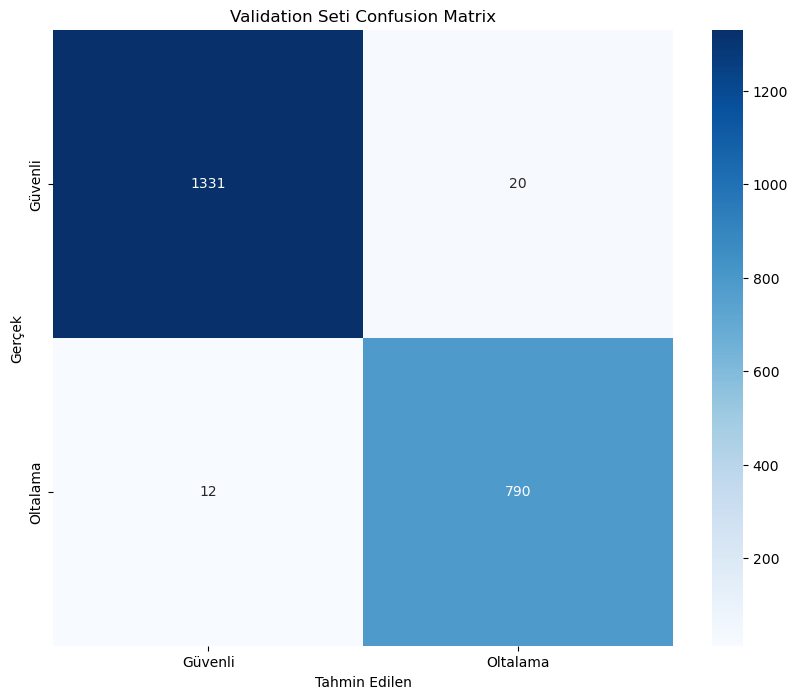


Validation Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1331
False Positives (Güvenli yanlış tahmin): 20
False Negatives (Oltalama yanlış tahmin): 12
True Positives (Oltalama doğru tahmin): 790


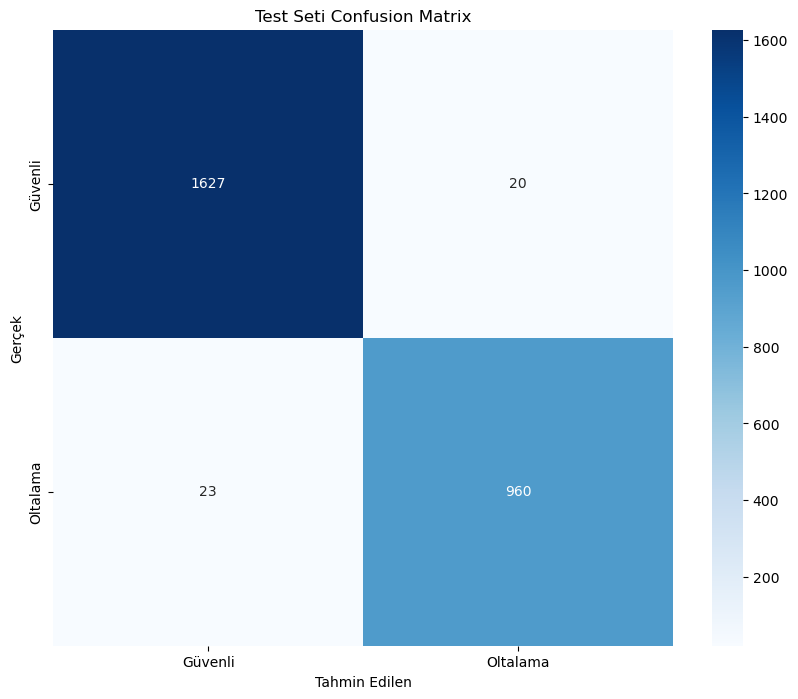


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1627
False Positives (Güvenli yanlış tahmin): 20
False Negatives (Oltalama yanlış tahmin): 23
True Positives (Oltalama doğru tahmin): 960

Validation metrikleri:
val_accuracy: 0.9851
val_precision: 0.9753
val_recall: 0.9850
val_f1: 0.9801

Test metrikleri:
test_accuracy: 0.9837
test_precision: 0.9796
test_recall: 0.9766
test_f1: 0.9781


In [16]:

# Filtrelenmiş veri seti için eğitim
model, val_pred, test_pred = train_and_evaluate_svm(
    train_data=filtered_train_final,
    val_data=filtered_val_data,
    test_data=filtered_test_data,
    dataset_name="filtered_data",
    experiment_name=experiment_name,
    out_dir=os.path.join(os.path.dirname(os.getcwd()), "source", "models", "svm","filtered"),
    text_column='email_text'
)


2024/12/31 02:18:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Modeller kaydedildi:
SVM: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/svm/cleaned/cleaned_data_svm.joblib
TF-IDF: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/svm/cleaned/cleaned_data_tfidf.joblib


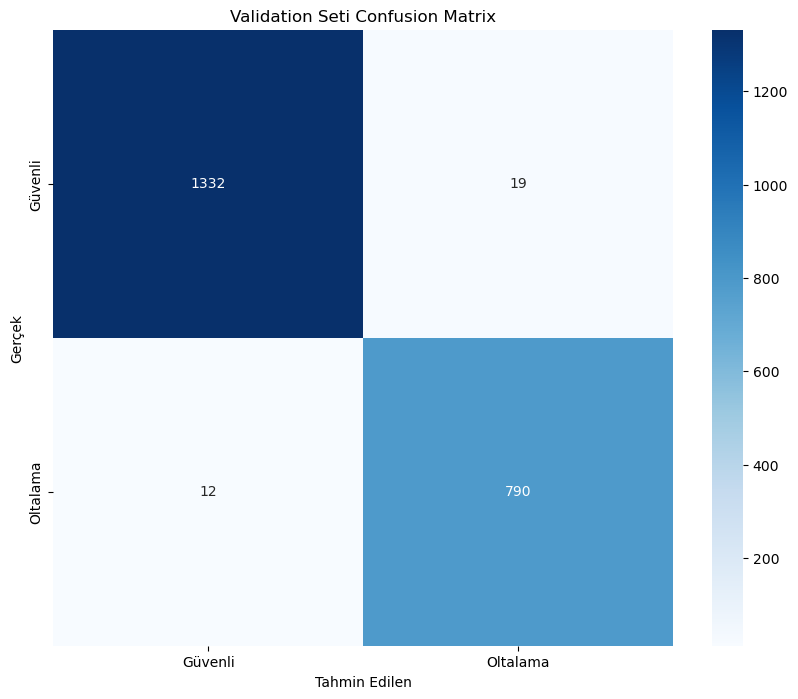


Validation Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1332
False Positives (Güvenli yanlış tahmin): 19
False Negatives (Oltalama yanlış tahmin): 12
True Positives (Oltalama doğru tahmin): 790


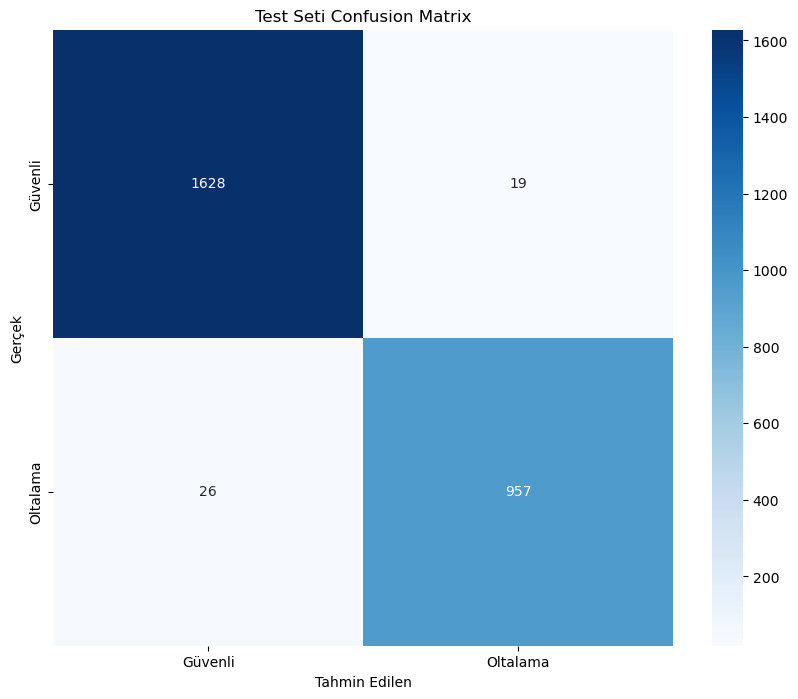


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1628
False Positives (Güvenli yanlış tahmin): 19
False Negatives (Oltalama yanlış tahmin): 26
True Positives (Oltalama doğru tahmin): 957

Validation metrikleri:
val_accuracy: 0.9856
val_precision: 0.9765
val_recall: 0.9850
val_f1: 0.9808

Test metrikleri:
test_accuracy: 0.9829
test_precision: 0.9805
test_recall: 0.9736
test_f1: 0.9770


In [17]:
# Temizlenmiş veri seti için eğitim
model, val_pred, test_pred = train_and_evaluate_svm(
    train_data=cleaned_train_final,
    val_data=cleaned_val_data,
    test_data=cleaned_test_data,
    dataset_name="cleaned_data",
    experiment_name=experiment_name,
    out_dir=os.path.join(os.path.dirname(os.getcwd()), "source", "models", "svm","cleaned"),
    text_column='cleaned_text'
)

## Cross Validation ile SVM Eğitimi

Cross validation kullanılarak SVM modeli eğitilir. 5 ve 10 katlı cross validation yapıldığında başarım farklılık göstermediği için 5 katlı cross validation yapıldı.

| Veri Seti | Model | Set | Accuracy | Precision | Recall | F1 Score |
|-----------|-------|------------------|-----------|------------|---------|-----------|
| Ham | SVM | CV-5 | 0.9807 ± 0.0033 | 0.9696 ± 0.0067 | 0.9790 ± 0.0038 | 0.9743 ± 0.0043 |
| Ham | SVM | Test | 0.9844 | 0.9806| 0.9776 |0.9791 |
| Filtrelenmiş | SVM | CV-5 | 0.9802 ± 0.0019 | 0.9703 ± 0.0041 | 0.9768 ± 0.0037 | 0.9735 ± 0.0026 |
| Filtrelenmiş | SVM | Test | 0.9844 | 0.9836 | 0.9746 | 0.9790 |
| Temizlenmiş | SVM | CV-5 | 0.9803 ± 0.0014 | 0.9708 ± 0.0021 | 0.9764 ± 0.0039 | 0.9736 ± 0.0019 |
| Temizlenmiş | SVM | Test | 0.9848 | 0.9826 | 0.9766 | 0.9796 |

Not: Cross Validation sonuçları "ortalama ± standart sapma" formatında gösterilmiştir.

In [1]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import numpy as np
import joblib


def train_and_evaluate_svm_cv(train_data, test_data, dataset_name, 
                              experiment_name, result_dir, text_column='text', cv=5):
    """
    Cross validation ile SVM modelini eğitir, lokale kaydeder ve MLflow'a loglar
    """
    # MLflow deneyini ayarla
    try:
        experiment = mlflow.get_experiment_by_name(experiment_name)
        if experiment is None:
            mlflow.create_experiment(experiment_name)
        mlflow.set_experiment(experiment_name)
    except Exception as e:
        print(f"MLflow ayarlanırken hata oluştu: {e}")
    
    # En iyi parametreler
    best_params = {
        'tfidf__max_features': 5000,
        'tfidf__ngram_range': (1, 2),
        'svm__kernel': 'rbf',
        'svm__class_weight': 'balanced',
        'svm__gamma': 'scale'
    }
    
    with mlflow.start_run(run_name=f"SVM_CV_{dataset_name}"):
        # TF-IDF ve SVM modellerini oluştur
        tfidf = TfidfVectorizer(
            max_features=best_params['tfidf__max_features'],
            ngram_range=best_params['tfidf__ngram_range']
        )
        
        svm = SVC(
            kernel=best_params['svm__kernel'],
            class_weight=best_params['svm__class_weight'],
            gamma=best_params['svm__gamma']
        )
        
        X_train_tfidf = tfidf.fit_transform(train_data[text_column])
        
        # Cross validation metrikleri
        scoring = ['accuracy', 'precision', 'recall', 'f1']
        cv_results = cross_validate(
            svm, 
            X_train_tfidf,
            train_data['label'],
            cv=cv,
            scoring=scoring,
            return_train_score=True
        )
        
        # CV metriklerini hesapla
        cv_metrics = {
            'cv_accuracy_mean': cv_results['test_accuracy'].mean(),
            'cv_accuracy_std': cv_results['test_accuracy'].std(),
            'cv_precision_mean': cv_results['test_precision'].mean(),
            'cv_precision_std': cv_results['test_precision'].std(),
            'cv_recall_mean': cv_results['test_recall'].mean(),
            'cv_recall_std': cv_results['test_recall'].std(),
            'cv_f1_mean': cv_results['test_f1'].mean(),
            'cv_f1_std': cv_results['test_f1'].std(),
        }
        
        # Final model eğitimi
        svm.fit(X_train_tfidf, train_data['label'])
        
        # Test seti tahminleri
        X_test_tfidf = tfidf.transform(test_data[text_column])
        test_pred = svm.predict(X_test_tfidf)
        
        # Test metrikleri
        test_metrics = {
            'test_accuracy': accuracy_score(test_data['label'], test_pred),
            'test_precision': precision_score(test_data['label'], test_pred),
            'test_recall': recall_score(test_data['label'], test_pred),
            'test_f1': f1_score(test_data['label'], test_pred)
        }
        
        # Confusion Matrix
        cm = confusion_matrix(test_data['label'], test_pred)
        plt.figure(figsize=(10,8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Normal', 'Phishing'],
                   yticklabels=['Normal', 'Phishing'])
        plt.title('Test Seti Confusion Matrix')
        plt.xlabel('Tahmin Edilen')
        plt.ylabel('Gerçek')
        
        os.makedirs(result_dir, exist_ok=True)
        cm_path = os.path.join(result_dir, f"confusion_matrix_{dataset_name}.png")
        plt.savefig(cm_path)
        mlflow.log_artifact(cm_path)
        plt.close()
        
        # MLflow'a parametreleri ve metrikleri kaydet
        mlflow.log_params({
            "dataset": dataset_name,
            "cv_folds": cv,
            **best_params
        })
        mlflow.log_metrics({**cv_metrics, **test_metrics})
        
        # MLflow'a modelleri kaydet
        mlflow.sklearn.log_model(svm, "svm_model")
        mlflow.sklearn.log_model(tfidf, "tfidf_vectorizer")
        
        
        # Model dosya yolları
        svm_path = os.path.join(result_dir, f"{dataset_name}_svm.joblib")
        tfidf_path = os.path.join(result_dir, f"{dataset_name}_tfidf.joblib")
        
        # Modelleri kaydet
        joblib.dump(svm, svm_path)
        joblib.dump(tfidf, tfidf_path)
        
        print(f"\nModeller kaydedildi:")
        print(f"SVM: {svm_path}")
        print(f"TF-IDF: {tfidf_path}")
        
        print(f"\nCV Metrikleri ({cv}-fold):")
        for metric, value in cv_metrics.items():
            print(f"{metric}: {value:.4f}")
            
        print(f"\nTest Metrikleri:")
        for metric, value in test_metrics.items():
            print(f"{metric}: {value:.4f}")
    
    return svm, tfidf, test_pred

In [2]:
experiment_name =  "SVM-CV-demo"


In [10]:
import pandas as pd
import os
experiment_name =  "SVM-Spam-CV-demo"

# spam dataset
data_dir = os.path.join(os.path.dirname(os.getcwd()),"source", "data", "spam_dataset")  
spam_train_data = pd.read_csv(os.path.join(data_dir, "spam_train.csv"))
spam_test_data = pd.read_csv(os.path.join(data_dir, "spam_test.csv"))
# 5-fold Cross Validation
svm_model_raw, tfidf_raw, test_pred_raw = train_and_evaluate_svm_cv(
    train_data=spam_train_data,
    test_data=spam_test_data,
    dataset_name="spam_data",
    experiment_name=experiment_name,
    result_dir=os.path.join(os.path.dirname(os.getcwd()), "source", "models", "svm-cv"),
    text_column='text',
    cv=5
)


2025/01/05 01:02:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/01/05 01:02:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/01/05 01:02:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Modeller kaydedildi:
SVM: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/svm-cv/spam_data_svm.joblib
TF-IDF: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/svm-cv/spam_data_tfidf.joblib

CV Metrikleri (5-fold):
cv_accuracy_mean: 0.9979
cv_accuracy_std: 0.0010
cv_precision_mean: 0.9992
cv_precision_std: 0.0010
cv_recall_mean: 0.9966
cv_recall_std: 0.0023
cv_f1_mean: 0.9979
cv_f1_std: 0.0010

Test Metrikleri:
test_accuracy: 0.9958
test_precision: 1.0000
test_recall: 0.9920
test_f1: 0.9960


In [25]:

# 10-fold Cross Validation
svm_model_raw_cv10, tfidf_raw_cv10, test_pred_raw_cv10  = train_and_evaluate_svm_cv(
    train_data=raw_train_data,
    test_data=raw_test_data,
    dataset_name="raw_data_cv10",
    experiment_name=experiment_name,
    result_dir=os.path.join(os.path.dirname(os.getcwd()), "source", "results", "svm-cv","raw-cv10"),
    text_column='email_text',
    cv=10
)

2024/12/31 02:52:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/31 02:52:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/12/31 02:52:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Modeller kaydedildi:
SVM: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/results/svm-cv/raw-cv10/raw_data_cv10_svm.joblib
TF-IDF: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/results/svm-cv/raw-cv10/raw_data_cv10_tfidf.joblib

CV Metrikleri (10-fold):
cv_accuracy_mean: 0.9812
cv_accuracy_std: 0.0046
cv_precision_mean: 0.9704
cv_precision_std: 0.0084
cv_recall_mean: 0.9797
cv_recall_std: 0.0077
cv_f1_mean: 0.9750
cv_f1_std: 0.0061

Test Metrikleri:
test_accuracy: 0.9844
test_precision: 0.9806
test_recall: 0.9776
test_f1: 0.9791


In [26]:


# Filtrelenmiş veri için
svm_model_filtered_cv10, tfidf_filtered_cv10, test_pred_filtered_cv10 = train_and_evaluate_svm_cv(
    train_data=filtered_train_data,
    test_data=filtered_test_data,
    dataset_name="filtered_data_cv5",
    experiment_name=experiment_name,
    result_dir=os.path.join(os.path.dirname(os.getcwd()), "source", "models", "svm-cv","filtered-cv5"),
    text_column='email_text',
    cv=5
)


2024/12/31 03:01:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/31 03:01:10 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/12/31 03:01:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Modeller kaydedildi:
SVM: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/results/svm-cv/filtered-cv5/filtered_data_cv5_svm.joblib
TF-IDF: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/results/svm-cv/filtered-cv5/filtered_data_cv5_tfidf.joblib

CV Metrikleri (5-fold):
cv_accuracy_mean: 0.9802
cv_accuracy_std: 0.0019
cv_precision_mean: 0.9703
cv_precision_std: 0.0041
cv_recall_mean: 0.9768
cv_recall_std: 0.0037
cv_f1_mean: 0.9735
cv_f1_std: 0.0026

Test Metrikleri:
test_accuracy: 0.9844
test_precision: 0.9836
test_recall: 0.9746
test_f1: 0.9790


In [27]:


# Temizlenmiş veri için
svm_model_cleaned_cv10, tfidf_cleaned_cv10, test_pred_cleaned_cv10 = train_and_evaluate_svm_cv(
    train_data=cleaned_train_data,
    test_data=cleaned_test_data,
    dataset_name="cleaned_data_cv5",
    experiment_name=experiment_name,
    result_dir=os.path.join(os.path.dirname(os.getcwd()), "source", "models", "svm-cv","cleaned-cv5"),
    text_column='cleaned_text',
    cv=5
)


2024/12/31 03:06:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/31 03:06:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/12/31 03:06:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Modeller kaydedildi:
SVM: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/results/svm-cv/cleaned-cv5/cleaned_data_cv5_svm.joblib
TF-IDF: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/results/svm-cv/cleaned-cv5/cleaned_data_cv5_tfidf.joblib

CV Metrikleri (5-fold):
cv_accuracy_mean: 0.9803
cv_accuracy_std: 0.0014
cv_precision_mean: 0.9708
cv_precision_std: 0.0021
cv_recall_mean: 0.9764
cv_recall_std: 0.0039
cv_f1_mean: 0.9736
cv_f1_std: 0.0019

Test Metrikleri:
test_accuracy: 0.9848
test_precision: 0.9826
test_recall: 0.9766
test_f1: 0.9796
